# ※当ノートは2周目のノートになります。

# Sprint 機械学習フロー

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb

/Users/adachi-yuya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/adachi-yuya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: `

## 【問題1】クロスバリデーション
事前学習期間では検証データをはじめに分割しておき、それに対して指標値を計算することで検証を行っていました。（ホールドアウト法）しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション（交差検証） を行います。分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割のためにscikit-learnにはKFoldクラスが用意されています。


事前学習期間の課題で作成したベースラインモデルに対してKFoldクラスによるクロスバリデーションを行うコードを作成し実行してください。


sklearn.model_selection.KFold — scikit-learn 0.21.3 documentation


## 2週目のテーマ
- 前処理を重点的に
- lightGBMを学習モデルとして使う
- 問題3−5を重点的に解く

In [51]:
df_train = pd.read_csv("../Week4/application_train.csv")
df_test = pd.read_csv("../Week4/application_test.csv")
display(df_train.head())
display(df_train.shape)
display(df_test.head())
display(df_test.shape)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


(307511, 122)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


(48744, 121)

In [52]:
# 欠損値処理
df_train.fillna(df_train.median(), inplace=True)
df_test.fillna(df_test.median(), inplace=True)

In [53]:
df_test.isnull().sum()

SK_ID_CURR                        0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
CNT_CHILDREN                      0
AMT_INCOME_TOTAL                  0
AMT_CREDIT                        0
AMT_ANNUITY                       0
AMT_GOODS_PRICE                   0
NAME_TYPE_SUITE                 911
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
REGION_POPULATION_RELATIVE        0
DAYS_BIRTH                        0
DAYS_EMPLOYED                     0
DAYS_REGISTRATION                 0
DAYS_ID_PUBLISH                   0
OWN_CAR_AGE                       0
FLAG_MOBIL                        0
FLAG_EMP_PHONE                    0
FLAG_WORK_PHONE                   0
FLAG_CONT_MOBILE                  0
FLAG_PHONE                        0
FLAG_EMAIL                        0
OCCUPATION_TYPE             

In [54]:
# NAME_TYPE_SUITE とOCCUPATION_TYPE の確認
display(df_train[df_train["NAME_TYPE_SUITE"].isnull() == True].iloc[:, 10:].head())
display(df_train[df_train["OCCUPATION_TYPE"].isnull() == True].iloc[:, 20:].head())

,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
64,315000.0,NaN,Commercial associate,Secondary / secondary special,Married,House / apartment,0.028663,-13866,-2546,-5448.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
724,450000.0,NaN,Commercial associate,Secondary / secondary special,Married,House / apartment,0.024610,-10072,-381,-519.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1199,477000.0,NaN,Working,Secondary / secondary special,Civil marriage,House / apartment,0.046220,-21717,-2393,-5486.0,...,0,0,0,0,0.0,0.0,0.0,4.0,0.0,0.0
1669,832500.0,NaN,State servant,Higher education,Separated,House / apartment,0.024610,-12975,-1839,-3896.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1862,243000.0,NaN,Commercial associate,Secondary / secondary special,Married,House / apartment,0.010147,-12870,-2822,-777.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0


,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
8,-3514,9.0,1,0,0,1,0,0,NaN,2.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
11,-2512,9.0,1,0,0,1,1,0,NaN,2.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
23,-3684,9.0,1,0,0,1,1,0,NaN,2.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
28,-2661,1.0,1,1,0,1,0,1,NaN,1.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
30,-3787,9.0,1,1,0,1,0,1,NaN,2.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,5.0


In [55]:
df_train["NAME_TYPE_SUITE"].unique()

array(['Unaccompanied', 'Family', 'Spouse, partner', 'Children',
       'Other_A', nan, 'Other_B', 'Group of people'], dtype=object)

In [56]:
df_train["OCCUPATION_TYPE"].unique()

array(['Laborers', 'Core staff', 'Accountants', 'Managers', nan,
       'Drivers', 'Sales staff', 'Cleaning staff', 'Cooking staff',
       'Private service staff', 'Medicine staff', 'Security staff',
       'High skill tech staff', 'Waiters/barmen staff',
       'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff',
       'HR staff'], dtype=object)

In [57]:
#NAME_TYPE_SUITE とOCCUPATION_TYPEについては最頻値で補完する
df_train["NAME_TYPE_SUITE"].fillna(df_train["NAME_TYPE_SUITE"].mode()[0], inplace=True)
df_train["OCCUPATION_TYPE"].fillna(df_train["OCCUPATION_TYPE"].mode()[0], inplace=True)

In [58]:
# 再度確認
df_train.isnull().sum()

SK_ID_CURR                    0
TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
CNT_CHILDREN                  0
AMT_INCOME_TOTAL              0
AMT_CREDIT                    0
AMT_ANNUITY                   0
AMT_GOODS_PRICE               0
NAME_TYPE_SUITE               0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
REGION_POPULATION_RELATIVE    0
DAYS_BIRTH                    0
DAYS_EMPLOYED                 0
DAYS_REGISTRATION             0
DAYS_ID_PUBLISH               0
OWN_CAR_AGE                   0
FLAG_MOBIL                    0
FLAG_EMP_PHONE                0
FLAG_WORK_PHONE               0
FLAG_CONT_MOBILE              0
FLAG_PHONE                    0
FLAG_EMAIL                    0
OCCUPATION_TYPE               0
CNT_FAM_MEMBERS               0
                             ..
DEF_30_C

In [59]:
# df_testにも同じ処置をしておく
df_test["NAME_TYPE_SUITE"].fillna(df_test["NAME_TYPE_SUITE"].mode()[0], inplace=True)
df_test["OCCUPATION_TYPE"].fillna(df_test["OCCUPATION_TYPE"].mode()[0], inplace=True)

df_test.isnull().sum()

SK_ID_CURR                    0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
CNT_CHILDREN                  0
AMT_INCOME_TOTAL              0
AMT_CREDIT                    0
AMT_ANNUITY                   0
AMT_GOODS_PRICE               0
NAME_TYPE_SUITE               0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
REGION_POPULATION_RELATIVE    0
DAYS_BIRTH                    0
DAYS_EMPLOYED                 0
DAYS_REGISTRATION             0
DAYS_ID_PUBLISH               0
OWN_CAR_AGE                   0
FLAG_MOBIL                    0
FLAG_EMP_PHONE                0
FLAG_WORK_PHONE               0
FLAG_CONT_MOBILE              0
FLAG_PHONE                    0
FLAG_EMAIL                    0
OCCUPATION_TYPE               0
CNT_FAM_MEMBERS               0
REGION_RATING_CLIENT          0
                             ..
DEF_30_C

In [60]:
# 別の方法でobject型の特徴量を探す
df_train.select_dtypes(exclude=[int, float])

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN
5,Cash loans,M,N,Y,"Spouse, partner",State servant,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Other,NaN,NaN,NaN,NaN
6,Cash loans,F,Y,Y,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,Accountants,SUNDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
7,Cash loans,M,Y,Y,Unaccompanied,State servant,Higher education,Married,House / apartment,Managers,MONDAY,Other,NaN,NaN,NaN,NaN
8,Cash loans,F,N,Y,Children,Pensioner,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,XNA,NaN,NaN,NaN,NaN
9,Revolving loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,THURSDAY,Electricity,NaN,NaN,NaN,NaN


In [61]:
df_train["FONDKAPREMONT_MODE"].dtypes

dtype('O')

## dtype('O')について調査
[参考](https://www.it-swarm.dev/ja/python/dtype%EF%BC%88-'o'%EF%BC%89%E3%81%A8%E3%81%AF%E4%BD%95%E3%81%A7%E3%81%99%E3%81%8B%EF%BC%9F/826401703/)  

pythonのobject型であることがわかる。
欠損値も多いので、今回は削除する（後日pandas型に変換するやり方について調査する）

In [62]:
df_train_1 = df_train.drop(["FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE"], axis=1)
df_test_1 = df_test.drop(["FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE"], axis=1)

In [63]:
# カテゴリ変数へラベルエンコーディング
from sklearn.preprocessing import LabelEncoder

categorical_feats = df_train_1.dtypes[df_train_1.dtypes == "object"].index

for cols in categorical_feats:
    le = LabelEncoder()
    df_train_1[cols] = le.fit_transform(df_train_1[cols])
    df_test_1[cols] = le.fit_transform(df_test_1[cols])

In [64]:
df_train_1.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## 【問題1】クロスバリデーション
事前学習期間では検証データをはじめに分割しておき、それに対して指標値を計算することで検証を行っていました。（ホールドアウト法）しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション（交差検証） を行います。分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割のためにscikit-learnにはKFoldクラスが用意されています。


事前学習期間の課題で作成したベースラインモデルに対してKFoldクラスによるクロスバリデーションを行うコードを作成し実行してください。


sklearn.model_selection.KFold — scikit-learn 0.21.3 documentation

In [65]:
# Xとyに分割する
X = df_train_1.iloc[:, 2:]
y = df_train_1.iloc[:, 1]

In [66]:
from sklearn import metrics

def get_evaluate(y_test, predict):

    fpr, tpr, thr_arr = metrics.roc_curve(y_test, predict)

    auc = metrics.auc(fpr, tpr)
    precision = metrics.precision_score(y_test, predict)
    recall = metrics.recall_score(y_test, predict)

    return auc, precision, recall

## model1

In [70]:
# lightGBMで実行
K = 5

kf = KFold(n_splits=K)

lgbm_params = {'objective': 'binary'}

auc_list = []
precision_list = []
recall_list = []
predict_list = []

# KFold分割
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    scaler = StandardScaler()

    scaler.fit(X_train)   #後でスケーリングするために使用する平均と標準を計算します。
    X_train_scaler = scaler.transform(X_train)   # 標準化　センタリングとスケーリングによって標準化を実行する
    X_test_scaler = scaler.transform(X_test)     # 標準化　センタリングとスケーリングによって標準化を実行する

    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)
    
    # 学習
    model = lgb.train(lgbm_params, lgb_train)

    predict_proba = model.predict(X_test, num_iteration=model.best_iteration)
    
    # predict_probaが0.5以上なら1とする
    predict = [0 if i < 0.5 else 1 for i in predict_proba]
    
    auc, precision, recall = get_evaluate(y_test, predict)

    #print('AUC:{}, precision:{}, recall:{}'.format(auc, precision, recall))

    auc_list.append(auc)
    precision_list.append(precision)
    recall_list.append(recall)

# スコアテーブルを作成
score_list = []

for i in range(K):
    score_list.append((auc_list[i], precision_list[i], recall_list[i]))

score_table = pd.DataFrame(score_list, 
                           index=["KFold" + str(i) for i in range(K)], 
                           columns=["auc_score", "precision", "recall"])

display(score_table)
display(score_table.describe())

,auc_score,precision,recall
KFold0,0.506885,0.553030,0.014813
KFold1,0.508448,0.543860,0.018278
KFold2,0.506651,0.529412,0.014435
KFold3,0.508985,0.568862,0.019242
KFold4,0.507785,0.543046,0.016790


,auc_score,precision,recall
count,5.000000,5.000000,5.000000
mean,0.507751,0.547642,0.016712
std,0.000996,0.014553,0.002101
min,0.506651,0.529412,0.014435
25%,0.506885,0.543046,0.014813
50%,0.507785,0.543860,0.016790
75%,0.508448,0.553030,0.018278
max,0.508985,0.568862,0.019242


## 【問題2】グリッドサーチ
これまで分類器のパラメータには触れず、デフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになります。機械学習の前提として、パラメータは状況に応じて最適なものを選ぶ必要があります。最適なパラメータを探していくことを パラメータチューニング と呼びます。パラメータチューニングをある程度自動化する単純な方法としては グリッドサーチ があります。


scikit-learnのGridSearchCVを使い、グリッドサーチを行うコードを作成してください。そして、ベースラインモデルに対して何らかしらのパラメータチューニングを行なってください。どのパラメータをチューニングするかは、使用した手法の公式ドキュメントを参考にしてください。


sklearn.model_selection.GridSearchCV — scikit-learn 0.21.3 documentation


GridSearchCVクラスには引数としてモデル、探索範囲、さらにクロスバリデーションを何分割で行うかを与えます。クロスバリデーションの機能も含まれているため、これを使用する場合はKFoldクラスを利用する必要はありません。## 【問題2】グリッドサーチ
これまで分類器のパラメータには触れず、デフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになります。機械学習の前提として、パラメータは状況に応じて最適なものを選ぶ必要があります。最適なパラメータを探していくことを パラメータチューニング と呼びます。パラメータチューニングをある程度自動化する単純な方法としては グリッドサーチ があります。


scikit-learnのGridSearchCVを使い、グリッドサーチを行うコードを作成してください。そして、ベースラインモデルに対して何らかしらのパラメータチューニングを行なってください。どのパラメータをチューニングするかは、使用した手法の公式ドキュメントを参考にしてください。


sklearn.model_selection.GridSearchCV — scikit-learn 0.21.3 documentation


GridSearchCVクラスには引数としてモデル、探索範囲、さらにクロスバリデーションを何分割で行うかを与えます。クロスバリデーションの機能も含まれているため、これを使用する場合はKFoldクラスを利用する必要はありません。

## 【問題3】Kaggle Notebooksからの調査
KaggleのNotebooksから様々なアイデアを見つけ出して、列挙してください。

## 【問題4】高い汎化性能のモデル作成
問題3で見つけたアイデアと、独自のアイデアを組み合わせ高い汎化性能のモデル作りを進めてください。


その過程として、何を行うことで、クロスバリデーションの結果がどの程度変化したかを表にまとめてください。


## 1周目でランダムフォレストでのグリッドサーチは済んでいるため割愛（時間も負荷もかかるため）2周目はグリッドサーチでもlightgbmを使う

## 前回メモを転載
- 一番最初に最下部「参考」セルの最近傍法で実施した。その後、グリッドサーチを行い、estimator=SVMで実施したが1時間30分実行結果が出ずに断念する。その間にkaggleを見ていると、lgbという学習モデルが良く使われていることに気づく。また、同ブレイクアウトルームの本木さん、池田さん、作間さんもグリッドサーチで時間がかかっているようで、皆kaggleを見ながら議論していた。  
  問題1をlgbモデルで学習させ、問題2のグリッドサーチでランダムフォレストを使い実行してみたところ、1分ほどで実行完了となった。parameterやcvの値を小さくしたことにより即完了したものと思われる。（後日cvを5にしたり、パラメーターを変更し再度実行する）
  また、そもそもXを量的変数のみとしているため、質的変数のダミー変数化をし、特徴量を増やし実行することも忘れない。


- https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction  

  - KFoldを使い指標値を出していた。70セルのスコアテーブルが参考になった。
  - 学習モデルはlgbモデルを使っていた。

- https://www.kaggle.com/osciiart/homecreditrisk-extensive-eda-baseline-model-jp

  - Kfoldを使わずに、train_test_splitで分割し、こちらも学習モデルはlgbモデル。

- lgbモデルについて調査
  - 「kaggle上位ランカーが良く使う」「LightGBMは「Leaf-wise」という手法を採用」「LigtGBMでは訓練データの特徴量を階級に分けてヒストグラム化することで、意図的に厳密な枝分かれを探さず大規模なデータセットに対しても計算コストを抑えることが可能なのです。」
  - ポイント  
    -モデル訓練に掛かる時間が短い   
    -メモリ効率が高い   
    -推測精度が高い   
    -過学習しやすい   
    -大規模なデータセットも訓練可能  
    
  
  
  - https://www.codexa.net/lightgbm-beginner/
  - https://qiita.com/dev_fukuro/items/2235fbe026622438989d
  
  
## (ボツメモ)Kaggleで人気上位のLGBMを学習モデルとしてグリッドサーチすることにする。

- modelをLGBMClassifierとしグリッドサーチするものの、1時間程度待っても結果が実行されない。
  -  要因として
    -  LGBM（ダウンロードしたばかりですし、参考ページを見ながらの実施だったため、メソッドの使い方がわかっておらずコーディングが間違っている可能性
    -  [参考1](https://stackoverrun.com/ja/q/12370570) や[参考2](https://yottagin.com/?p=9905)などがあり真偽不明ですが、gridsearchでLGBMを使うことは難しいのではと思い、ランダムフォレストでパラメーターを増やし実行に移してみた。
   
- ランダムフォレストで参考にしたページ
  - https://qiita.com/ragAgar/items/2f6bebdba5f9d7381310

## model2
⇩以下は[参考](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search)から写経

In [72]:
from sklearn.model_selection import train_test_split

# df_train_1をベースのデータフレームとする

# Sample 16000 rows (10000 for training, 6000 for testing)
features = df_train_1.sample(n = 16000, random_state = 42)

# Only numeric features
features = features.select_dtypes('number')

# Extract the labels
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 50)

In [73]:
print("Training features shape: ", train_features.shape)
print("Testing features shape: ", test_features.shape)

Training features shape:  (10000, 116)
Testing features shape:  (6000, 116)


In [74]:
# Create a training and testing dataset
train_set = lgb.Dataset(data = train_features, label = train_labels)
test_set = lgb.Dataset(data = test_features, label = test_labels)

In [75]:
N_FOLDS = 5
MAX_EVALS = 5

# Get default hyperparameters
model = lgb.LGBMClassifier()
default_params = model.get_params()

# Remove the number of estimators because we set this to 10000 in the cv call
del default_params['n_estimators']

# Cross validation with early stopping
cv_results = lgb.cv(default_params, train_set, num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS, seed = 42)

/Users/adachi-yuya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/lightgbm/basic.py:794: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


In [76]:
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['auc-mean'])))

The maximum validation ROC AUC was: 0.71114 with a standard deviation of 0.01228.
The optimal number of boosting rounds (estimators) was 30.


## ハイパーパラメーターチューニングについての記述和訳
ハイパーパラメータチューニングの4つの部分¶。
ハイパーパラメータのチューニングには4つの部分があると考えると便利です（この4つの部分はベイズ最適化の基礎を形成します）。

目的関数：ハイパーパラメータを取り込み、最小化または最大化しようとしているスコアを返す関数
領域：探索したいハイパーパラメータ値の集合．
アルゴリズム：目的関数で評価するハイパーパラメータの次のセットを選択するための方法．
結果履歴：ハイパーパラメータの各セットと、目的関数の結果のスコアを含むデータ構造。
グリッド検索からランダム検索からベイズ最適化への切り替えは、これらの4つの部分にわずかな変更を加えるだけで済みます。

## early stoppingについての記述和訳
これらの中には、サイレント、客観的、ランダム状態、n_jobs のように調整する必要のないものもあり、おそらく最も重要なハイパーパラメータである、訓練された個々の学習者の数である n_estimators (num_boost_rounds や反復回数とも呼ばれる) を決定するために、早期停止を使用します。例えば、min_child_samplesとmin_child_weightは、葉の観測要件の最小値を調整することで、個々の決定木の複雑さを制限するので、我々は1つだけ調整します。しかし、最適化すべきハイパーパラメータはまだたくさんあるので、10個のハイパーパラメータを選んで調整します。

ハイパーパラメータのグリッドを選択することは、おそらくハイパーパラメータのチューニングの中で最も難しい部分です。さらに，ハイパーパラメータはお互いに複雑な相互作用を持っているので，一度に1つずつチューニングしてもうまくいかない．

モデルを使った経験があれば、ハイパーパラメータの最適な値が一般的にどこにあるか、あるいは良い探索空間とは何かを知っているかもしれません。しかし、あまり経験がない場合は、単純に大きな探索空間を定義して、どこかに最良の値があることを期待することができます。通常、最初にメソッドを使うときは、デフォルト値を中心とした広い探索空間を定義します。そして、ハイパーパラメータのいくつかの値の方がうまくいく傾向があることがわかったら、その値を中心に検索を集中させます。

10個のハイパーパラメータの完全なグリッドを以下に定義します。ディショナリーの各値はリストでなければならないので、各ハイパーパラメータの値の範囲を定義するために、range, np.linspace, np.logspaceを組み合わせたリストを使っています。

www.DeepL.com/Translator（無料版）で翻訳しました。

In [77]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.73621 ROC AUC on the test set.


In [78]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 42)
    
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

In [79]:
score, params, iteration = objective(default_params, 1)

print('The cross-validation ROC AUC was {:.5f}.'.format(score))

The cross-validation ROC AUC was 0.71114.


In [80]:
# Create a default model
model = lgb.LGBMModel()
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [81]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

In [82]:
import random

random.seed(50)

# Randomly sample a boosting type
boosting_type = random.sample(param_grid['boosting_type'], 1)[0]

# Set subsample depending on boosting type
subsample = 1.0 if boosting_type == 'goss' else random.sample(param_grid['subsample'], 1)[0]

print('Boosting type: ', boosting_type)
print('Subsample ratio: ', subsample)

Boosting type:  goss
Subsample ratio:  1.0


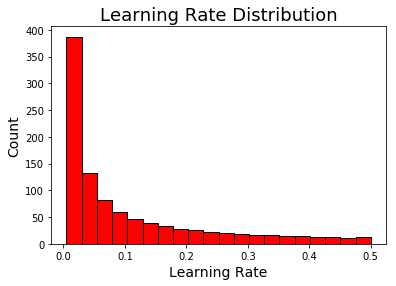

In [83]:
# Learning rate histogram
plt.hist(param_grid['learning_rate'], bins = 20, color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

In [84]:
a = 0
b = 0

# Check number of values in each category
for x in param_grid['learning_rate']:
    # Check values
    if x >= 0.005 and x < 0.05:
        a += 1
    elif x >= 0.05 and x < 0.5:
        b += 1

print('There are {} values between 0.005 and 0.05'.format(a))
print('There are {} values between 0.05 and 0.5'.format(b))

There are 499 values between 0.005 and 0.05
There are 499 values between 0.05 and 0.5


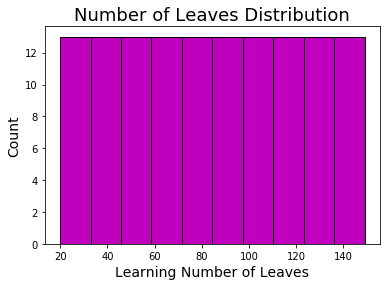

In [85]:
# number of leaves domain
plt.hist(param_grid['num_leaves'], color = 'm', edgecolor = 'k')
plt.xlabel('Learning Number of Leaves', size = 14); plt.ylabel('Count', size = 14); plt.title('Number of Leaves Distribution', size = 18);

In [86]:
# Dataframes for random and grid search
random_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))


In [87]:
com = 1
for x in param_grid.values():
    com *= len(x)
print('There are {} combinations'.format(com))

There are 2620800000000000 combinations


In [88]:
print('This would take {:.0f} years to finish.'.format((100 * com) / (60 * 60 * 24 * 365)))

This would take 8310502283 years to finish.


## 和訳
もっと良いアプローチが必要だと思います。代替案を議論する前に、このグリッドを実際に使用して、すべてのハイパーパラメータを評価する方法を説明しましょう。

以下のコードは、グリッド検索の「アルゴリズム」を示しています。まず、ハイパーパラメータグリッド（Pythonの辞書）の値を展開します。キーとなる行は v in itertools.product(*values) で、ハイパーパラメータグリッド内のすべての値の可能な組み合わせを一度に一つずつ反復処理します。それぞれの値の組み合わせについて、hyperparameters = dict(zip(keys, v))という辞書を作成し、先ほど定義した目的関数に渡します。客観関数は、データフレームに記録したハイパーパラメータからクロスバリデーションのスコアを返します。この処理は、ハイパーパラメータの値の組み合わせごとに繰り返されます。itertools.product（このStack Overflowの質問と回答から）を使用することで、可能なすべての組み合わせのリストを割り当てるのではなく、ジェネレーターを作成します。

通常、グリッド検索では評価数を制限することはありません。評価の数は、ハイパーパラメータグリッドの組み合わせの総数（あるいは待つことができる年数）によって設定されます。そのため、実際のグリッド検索では、この線は使用されません。ここでは、例としてグリッド検索を5回繰り返してみます。返された結果は、検証スコア（ROC AUC）、ハイパーパラメータ、およびハイパーパラメータ値の最も性能の良い組み合わせでソートされた反復が表示されます。

www.DeepL.com/Translator（無料版）で翻訳しました。



In [89]:
import itertools

def grid_search(param_grid, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals) グリッド検索アルゴリズム(最大値に制限あり)"""
    
    # Dataframe to store results 結果を保存するデータフレーム
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters ハイパーパラメタのあらゆる組み合わせを反復処理する
    for v in itertools.product(*values):
        
        # Create a hyperparameter dictionary ハイパーパラメータ辞書の作成
        hyperparameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type ブースティング型を考慮したサブサンプル比率を設定する
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']
        
        # Evalute the hyperparameters ハイパーパラメータを評価する
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # Normally would not limit iterations 通常は繰り返しを制限しない
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top トップのベストスコアでソート
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results

In [90]:
grid_results = grid_search(param_grid)

print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])

The best validation score was 0.73105

The best hyperparameters were:
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6,
 'is_unbalance': True,
 'learning_rate': 0.004999999999999999,
 'min_child_samples': 20,
 'n_estimators': 963,
 'num_leaves': 20,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.5,
 'subsample_for_bin': 20000}


In [94]:
result = pd.DataFrame(grid_results)
result

,index,score,params,iteration
0,0,0.731053,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0
1,1,0.731053,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",1
2,2,0.731053,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",2
3,3,0.731053,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",3
4,4,0.731053,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",4
5,5,0.731053,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",5


## 理解したこと
- LGBMでグリッドサーチする場合は、.cvというメソッドを使うため、Gridsearchcvと使い方が違う。例えば引数のmodelにLGBMClassifierを入れても作用しない（1日目はここで時間を費やしてしまった）
- グリッドサーチするときは、パラメーターの数によっては膨大な時間と負荷がかかるため、if:Breakを使うことによって回避する。
- 西尾メンターも仰っていたこと、かつ、参考Kaggleでもパラメーターチューニングにベイズモデル（opotuna）の記述あり。グリッドサーチは手法の一つなので、ランダムサーチやOpotunaも覚えておかなければいけない。

## 参考ページからの重要な論点
ランダム検索とグリッド検索の積み重ね
ハイパーパラメータチューニングをよりスマートに実装するためのオプションの1つは、ランダム検索とグリッド検索を組み合わせることです。

大規模なハイパーパラメータ・グリッドでランダム検索を使用します。
ランダム検索の結果を使用して、最も性能の高いハイパーパラメータ値の周りに焦点を当てたハイパーパラメータ・グリッドを構築します。
縮小されたハイパーパラメータ・グリッドでグリッド検索を実行します。
最大の計算/時間バジェットを超えるまで、より多くの焦点を絞ったグリッドでグリッド検索を繰り返します。
後日（予定）のノートブックでは、過去の評価結果を利用して、目的関数で試すべき次のハイパーパラメータ値を選択する方法を見ていきます。これらの手法（ベイズ最適化を含む）は、基本的には、上で説明した戦略で行うことを実行します：過去の結果から、探索で試す次の値を調整します。これらのインフォームド・メソッドの全体的な目的は、過去の評価結果に基づいて、次に試すべき値を推論することによって、目的関数の評価を制限することです。したがって、これらのアルゴリズムは、ハイパーパラメータのより有望な値を評価することで、時間を節約することができます。これは本当にクールなトピックであり、ベイズ最適化はとても魅力的なので、今後のノートブックに期待しています。

www.DeepL.com/Translator（無料版）で翻訳しました。

## model3
1周目で使ったグリッドサーチ*ランダムフォレストのものを使用する。（X/yのデータセットが違うため値も違くなると想定）

In [95]:
# model3 (分割数を増やす・パラメータ数そのまま)
K = 5

rf = RandomForestClassifier()

param_grid = {
    "max_depth": [2,3, None],
    "n_estimators":[50],
    "max_features": [1, 3],
    "min_samples_leaf": [1, 3]
}

rf_grid = GridSearchCV(estimator=rf,
                 param_grid = param_grid,
                 scoring="roc_auc",  #metrics
                 cv = K,              #cross-validation
                 n_jobs =-1)          #number of core

rf_grid.fit(X,y) #fit

rf_grid_best = rf_grid.best_estimator_ #best estimator
print("Best Model Parameter: ",rf_grid.best_params_)
print("Best Model Score    : ",rf_grid.best_score_)

Best Model Parameter:  {'max_depth': None, 'max_features': 3, 'min_samples_leaf': 3, 'n_estimators': 50}
Best Model Score    :  0.7062657971183655


In [107]:
score_list.append((grid_results.loc[0, 'score'], 0, 0))
score_list.append((rf_grid.best_score_, 0, 0))


In [110]:
score_list.pop(-3)

0.731052714536521

In [120]:
score_list.pop(1)

(0.5077854115439335, 0.543046357615894, 0.01678951678951679)

In [122]:
score_table = pd.DataFrame(score_list, 
                           index = ["LGBM(KFold4)", "LGBM(GridS)", "RandomF(GridS)"],
                           columns=["auc_score", "precision", "recall"])

In [127]:
score_table_fin = score_table.drop(score_table.iloc[: , 1:3], axis=1)

In [128]:
score_table_fin

,auc_score
LGBM(KFold4),0.508985
LGBM(GridS),0.706266
RandomF(GridS),0.731053


## 考察
- グリッドサーチや今回は知識のみとしてランダムサーチやOptunaなどハイパーパラメーターを機械的に最適化できる手法について学習できた。
- 2周目の学習では特徴量をほぼ全て選択しての実行となったが、1周目の量的変数のみ選択という強引な手法より指標値が上がり、前処理が最終的な学習にも大きく関係しており重要性について改めて認識した。

## 備忘メモ
- Kagglerより値が良くなったのは、model2のKaggleのコードは行数を分割データを10000/6000としているため！？それは置いておいて、train/testに分割する工程で任意で削除してもいいねということに気づけた。
- クロスバリデーション（KFold法）については、学習モデルが同じでも指標値がこれだけ変わるのかと。ハイパーパラメーターをチューニングしていないのでその関係だとしたらハイパーパラメーターの重要性が良くわかる。


##  【問題5】最終的なモデルの選定
最終的にこれは良いというモデルを選び、推定した結果をKaggleに提出してスコアを確認してください。どういったアイデアを取り入れ、どの程度のスコアになったかを記載してください。

## 最も指標値の高かったモデル3で推定する。

In [129]:
df_test_1.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [146]:
df_test_1_id = df_test_1.iloc[: , [0]]
df_test_1_id.head()

,SK_ID_CURR
0,100001
1,100005
2,100013
3,100028
4,100038


In [132]:
df_test_1_selected = df_test_1.drop(["SK_ID_CURR"], axis=1)

In [134]:
df_test_1_selected.shape

(48744, 116)

In [137]:
predict = rf_grid.predict_proba(df_test_1_selected)
predict
predict.shape

(48744, 2)

In [149]:
df_test_1_id["TARGET"] = predict[:, 1]
df_test_1_id

/Users/adachi-yuya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,SK_ID_CURR,TARGET
0,100001,0.067328
1,100005,0.057625
2,100013,0.011014
3,100028,0.038726
4,100038,0.059709
5,100042,0.043730
6,100057,0.049451
7,100065,0.048304
8,100066,0.020509
9,100067,0.051685


In [150]:
df_test_1_id.to_csv("submit.csv", index=False)

## 最終考察とスコア

- ①Week4授業課題で提出したcsv:0.51762
- ②1周目に提出したcsv:0.62772
- ③当ブックで作成・提出したcsv:0.67157

#### 変化について記述
- ①特徴量を2つのみ、学習モデルも1つと簡素な仕上げ
- ②特徴量を量的変数のみに絞り、ランダムフォレスト*グリッドサーチを学習モデルとした
- ③特徴量を（ほぼ）全変数として、ランダムフォレスト*グリッドサーチを学習モデルとした

「train/testの分割は任意・削減してもいいが、特徴量は本来減らさない方が良い」といったニュアンスの記述がkaggle内にもあり、今回スコアが上がったことも頷ける。特徴量を全て扱えるように前処理のスキルを高めたいと思った。
